### Linear Regression Model

We will proceed initially to use the last 3 years to model the data with a simple linear regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from collections import defaultdict
import re

In [2]:
year_from = 2005

def load_data(year_from):  
    assert isinstance(year_from,int)
    # Imports
    train = pd.read_csv('data/TrainingSet.csv',index_col=0)
    submission = pd.read_csv('data/SubmissionRows.csv',index_col=0)
    # Remove [YR****] and input '_' for last 3 cols
    train.columns = list(map(lambda x: re.findall(r'\d+',x)[0],train.columns[:36])) + list(map(lambda x: '_'.join(x.split()),train.columns[36:]))
    # Use last 3 years for predictions: This is subjected to change
    train = train.loc[:,f'{year_from}':]
    return train, submission

In [3]:
# Load data:
train, submission = load_data(2005)

In [4]:
def submission_data_missing(train,submission):    
    mask  = train.loc[submission.index,].T.isna().sum()>0
    train_X = train.loc[submission.index,]
    return train_X.loc[mask]

In [5]:
# 16 rows with missing values: Interpolate these values
submission_data_missing(train,submission)

,2005,2006,2007,Country_Name,Series_Code,Series_Name
8038,NaN,NaN,0.918215,Antigua and Barbuda,2.1,Achieve universal primary education
23347,NaN,0.162000,0.197000,Belarus,8.16,Develop a global partnership for development: ...
42800,NaN,0.982781,0.983149,Cambodia,2.1,Achieve universal primary education
52159,NaN,NaN,0.949294,Chile,2.1,Achieve universal primary education
64882,0.000373,NaN,0.000213,Cuba,5.1,Improve maternal health
80838,NaN,NaN,0.004100,Eritrea,8.16,Develop a global partnership for development: ...
85584,NaN,0.988391,0.996179,Fiji,2.1,Achieve universal primary education
105595,0.014000,NaN,0.045000,Guinea,6.7,Combat malaria and other diseases
107578,NaN,NaN,0.138000,Guyana,8.16,Develop a global partnership for development: ...
146351,NaN,NaN,0.005514,Liberia,8.16,Develop a global partnership for development: ...


In [6]:
def interpolate_data(train,submission):
    train_X = train.loc[submission.index,:]
    # Interpolate: Both directions are bfilled and ffilled respectively
    train_X.loc[:,:'2007'] = train_X.loc[:,:'2007'].interpolate(limit_direction='both',axis=1)
    return train_X

In [7]:
# Data:
data = interpolate_data(train,submission)

# Func to split that dataframe to values [2005,2006,2007] and [country_name,series_code,series_name]
def split_dataframe(data):
    raw_data = data.loc[:,:'2007']
    description = data.loc[:,'Country_Name':]
    return raw_data,description

In [8]:
# Split:
raw_data,description = split_dataframe(data)

In [9]:
# Export CSV:
raw_data.to_csv('data/raw_data.csv')
description.to_csv('data/description.csv')

In [10]:
def format_dataframe(raw_data):
    """
    Quick utility function to format dataframe into a X,y format with X = Numbers of years from the start, y = values.
    Example:
    Initial Dataframe being:
    2005   0.4
    2006   0.6
    2007   0.8
    
    The function transforms it into
    X   y
    0   0.4
    1   0.6
    2   0.8
    
    Returns: X,y
    
    Note: If we have 10 different timeseries (features) X.shape = (n_years,n_features) so slicing will be needed to predict
    individually.
    """
    # Extract index from raw data before transforming:
    raw_data_index = list(raw_data.index)
    raw_data.columns = raw_data.columns.astype('int')
    # Transponse to have time as index instead of columns
    raw_data = raw_data.T
    X = np.asarray(raw_data.index - raw_data.index[0]).reshape(-1,1)
    y = raw_data.values
    return X,y,raw_data_index

In [11]:
X,y,raw_data_index = format_dataframe(raw_data)

In [12]:
def linear_regression_poly(X,y,degree,year):
    assert isinstance(X,np.ndarray)
    assert isinstance(y,np.ndarray)
    assert isinstance(degree,int) and degree > 0
    assert year >= 2005
    year_pred = np.array([[year % year_from]])
    pipe = Pipeline([('poly',PolynomialFeatures(degree=degree)),('linear',LinearRegression())])
    n_features = y.shape[1]
    predictions_year = defaultdict(list)
    # Fit:
    for i in range(n_features):
        # slice each series:
        y_i = y[:,i]
        pipe.fit(X,y_i)
        # prediction value for year specified
        y_pred = pipe.predict(year_pred)[0]
        predictions_year[f'{year}[YR{year}]'].append(y_pred)
    
     # To dataframe: with correctly indexed submission values
    df = pd.DataFrame(predictions_year,index=raw_data_index)
    return df
        

In [13]:
# Predictions: Polynomial degree = 1:
_2008 = linear_regression_poly(X,y,1,2008).values
_2012 = linear_regression_poly(X,y,1,2012).values

# Into submission:
submission['2008 [YR2008]'] = _2008
submission['2012 [YR2012]'] = _2012
submission.head()

,2008 [YR2008],2012 [YR2012]
559,0.500000,0.640000
618,0.024196,0.037713
753,0.108367,0.095967
1030,0.001000,0.001000
1896,0.960667,0.958667


In [14]:
# Index mapper for plotting:
index_mapper = {k:index for index,k in enumerate(raw_data_index)}

# Plotting:
def plot_predictions(raw_data,description,pred_2008,pred_2012,n_features):
    pred_2008_values = pred_2008
    pred_2012_values = pred_2012
    pred_concat = np.concatenate([pred_2008_values,pred_2012_values],axis=1)
    random_indicators = np.random.choice(raw_data_index,size=n_features)
    # plot:
    fig,ax = plt.subplots(1,1,figsize=(14,8))
    ax.set_title(f'Values from {year_from} including pred: 2008, 2012')
    for i in random_indicators:
        values = raw_data.T.loc[:,i].values
        ax.plot([str(x) for x in range(year_from,2008)],values,label=f'{description.Country_Name[i]} : {description.Series_Name[i]}',marker='o')
        ax.plot(['2008','2012'],pred_concat[index_mapper[i],:],linestyle='--', label=f'{description.Country_Name[i]} : {description.Series_Name[i]} PRED',marker='o')
        ax.legend()

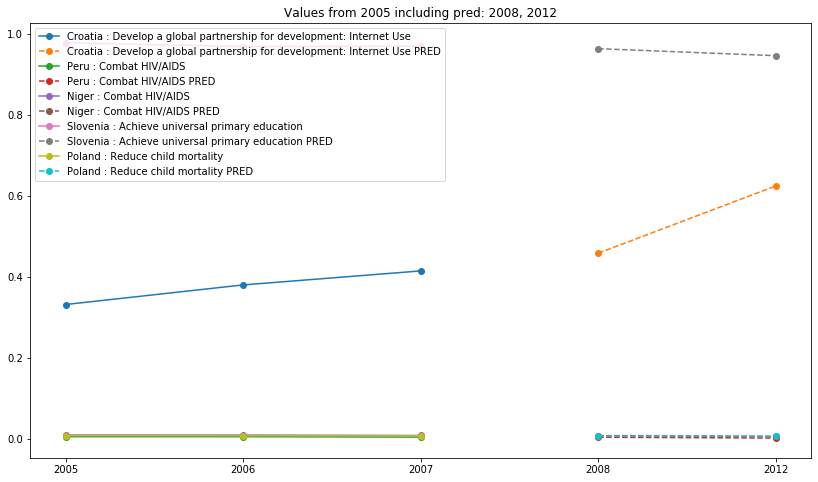

In [15]:
# Plot:
np.random.seed(2)
plot_predictions(raw_data,description,_2008,_2012,5)

In [16]:
# Predictions: Polynomial degree = 2:
_2008 = linear_regression_poly(X,y,2,2008).values
_2012 = linear_regression_poly(X,y,2,2012).values

# Into submission:
submission['2008 [YR2008]'] = _2008
submission['2012 [YR2012]'] = _2012
submission.head()

,2008 [YR2008],2012 [YR2012]
559,0.500000,0.640000
618,0.006028,-0.154871
753,0.108700,0.099500
1030,0.001000,0.001000
1896,0.959000,0.941000


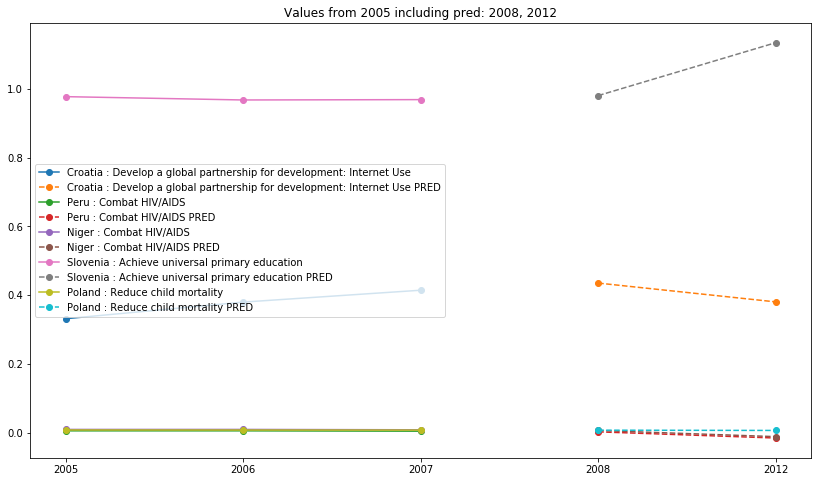

In [17]:
# Plot: degree = 2
np.random.seed(2)
plot_predictions(raw_data,description,_2008,_2012,5)

### Note:

Values from linear regression with degree = 1 scored higher (RMSE = 0.0549). Degree = 2 scored RMSE = 0.2483.

### Find correlated indicators

In [18]:

train, submission = load_data(1973)

In [19]:
kenya_data = train[train.Country_Name == 'Kenya']
kenya_values = kenya_data[[str(element) for element in range(2003,2007)]].values

# get the total number of time series we have for Kenya
nseries = kenya_values.shape[0]

# -1 as default
lag_corr_mat = np.ones([nseries, nseries], dtype=np.float64)*-1

# create a matrix to hold our lagged correlations
for i in range(nseries):
    for j in range(nseries):
        # skip comparing a series with itself
        if i!=j:
            # get original (1972-2006) and shifted (1973-2007)
            original = kenya_values[i,1:]
            shifted = kenya_values[j,:-1]

            # for just the indices where neither is nan
            non_nan_mask = (~np.isnan(original) & ~np.isnan(shifted))

            # if we have at least 2 data points
            if non_nan_mask.sum() >= 2:
                lag_corr_mat[i,j] = np.correlate(original[non_nan_mask], shifted[non_nan_mask])

In [20]:
# let's look at one of the indicators we are suppoed to predict
to_predict_ix = 131042 

# first, we get the index of that row in the correlation matrix
i = np.where(kenya_data.index.values == to_predict_ix)[0][0]

# then, we see which value in the matrix is the largest for that row
j_max = np.argmax(lag_corr_mat[i,:])

# finally, let's see what these correspond to
max_corr_ix = kenya_data.index.values[j_max]

# # now write out what we've found
# fmt_string = "In Kenya, the progress of '{}' is "\
#     "most correlated with a change in '{}' during the year before."
    
# print(kenya_data["Series Name"][to_predict_ix], kenya_data["Series Name"][max_corr_ix])
print(kenya_data.loc[to_predict_ix])
print()
print(kenya_data.loc[max_corr_ix])

1973                                            NaN
1974                                            NaN
1975                                            NaN
1976                                            NaN
1977                                            NaN
1978                                            NaN
1979                                            NaN
1980                                            NaN
1981                                            NaN
1982                                            NaN
1983                                            NaN
1984                                            NaN
1985                                            NaN
1986                                            NaN
1987                                            NaN
1988                                            NaN
1989                                            NaN
1990                                            NaN
1991                                            NaN
1992        

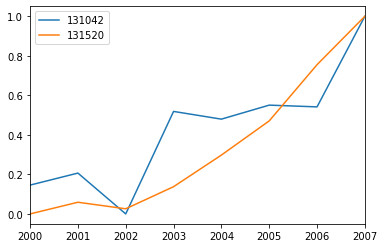

In [21]:
from sklearn.preprocessing import MinMaxScaler
correlated_indicators=train[train.index.isin([to_predict_ix,max_corr_ix])].loc[:,'2000':'2007'].T

pd.DataFrame(
    MinMaxScaler().fit_transform(correlated_indicators), 
    columns=correlated_indicators.columns, 
    index=correlated_indicators.index).plot()

In [22]:
df=pd.DataFrame(data=lag_corr_mat[0:,0:],
          index=kenya_data.index.values,
          columns=kenya_data.index.values)
df.head()

,131026,131027,131028,131030,131031,131032,131034,131035,131036,131037,...,132343,132344,132345,132354,132357,132358,132359,132360,132361,132362
131026,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
131027,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
131028,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
131030,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
131031,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [23]:
# df.loc[to_predict_ix,max_corr_ix]
top_10_indicators=np.abs(df.loc[to_predict_ix,:]).sort_values(ascending=False).iloc[0:10]

In [24]:
top_10_indicators_and_to_predict = np.append(to_predict_ix, top_10_indicators.index.values)

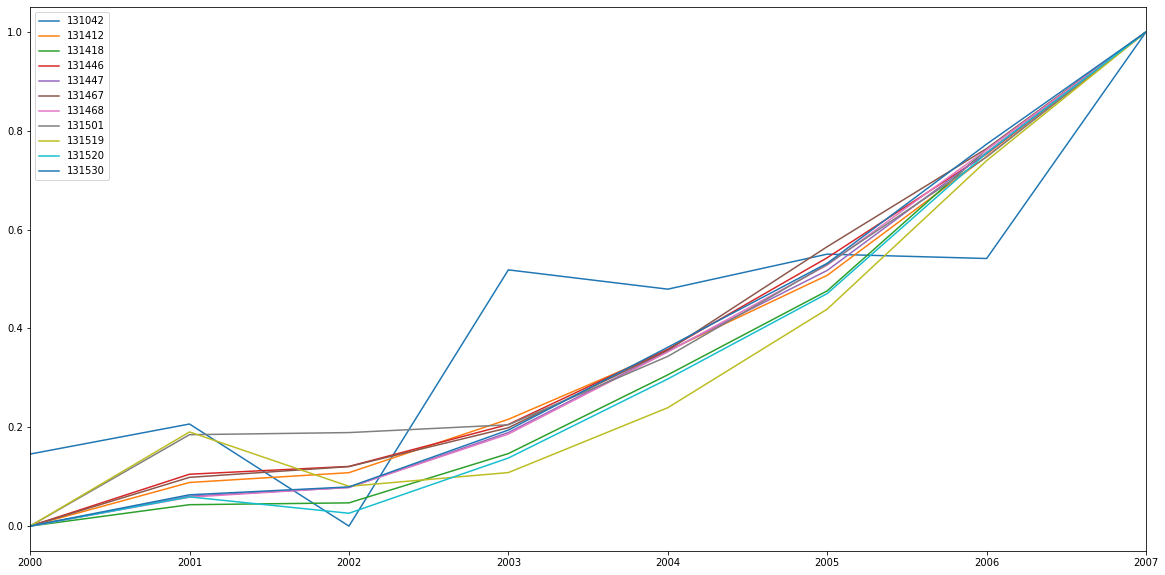

In [25]:
correlated_indicators=train[train.index.isin(top_10_indicators_and_to_predict)].loc[:,'2000':'2007'].T

pd.DataFrame(
    MinMaxScaler().fit_transform(correlated_indicators), 
    columns=correlated_indicators.columns, 
    index=correlated_indicators.index).plot(figsize=(20,10))

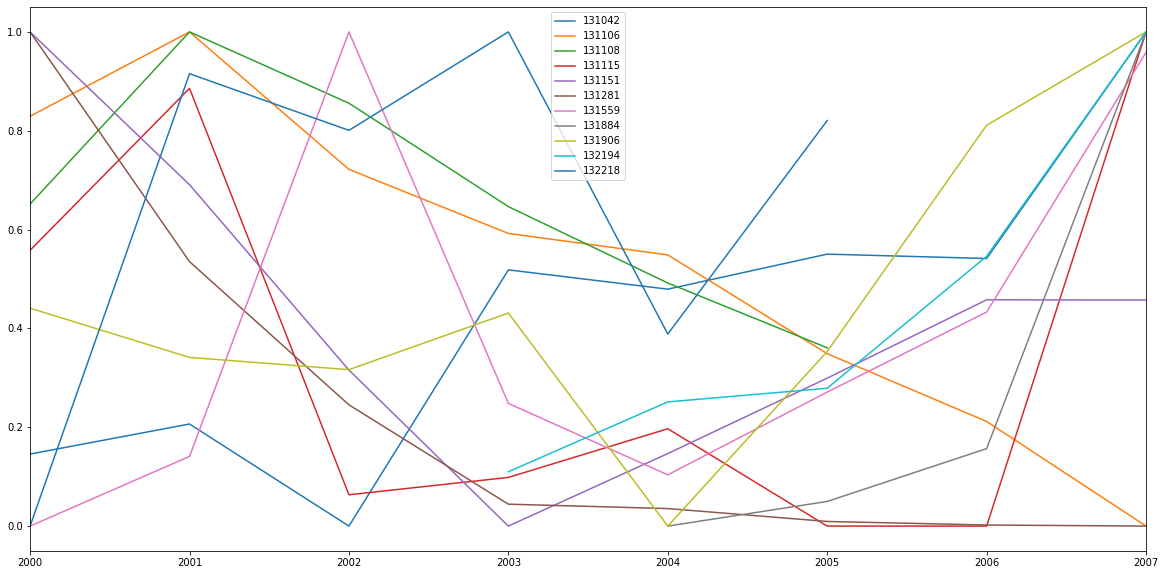

In [26]:

less_correlated_indicators=np.abs(df.loc[to_predict_ix,:]).sort_values(ascending=True).iloc[50:60].index.values
less_correlated_indicators=np.append(to_predict_ix, less_correlated_indicators)
less_correlated_indicators=train[train.index.isin(less_correlated_indicators)].loc[:,'2000':'2007'].T

pd.DataFrame(
    MinMaxScaler().fit_transform(less_correlated_indicators), 
    columns=less_correlated_indicators.columns, 
    index=less_correlated_indicators.index).plot(figsize=(20,10))

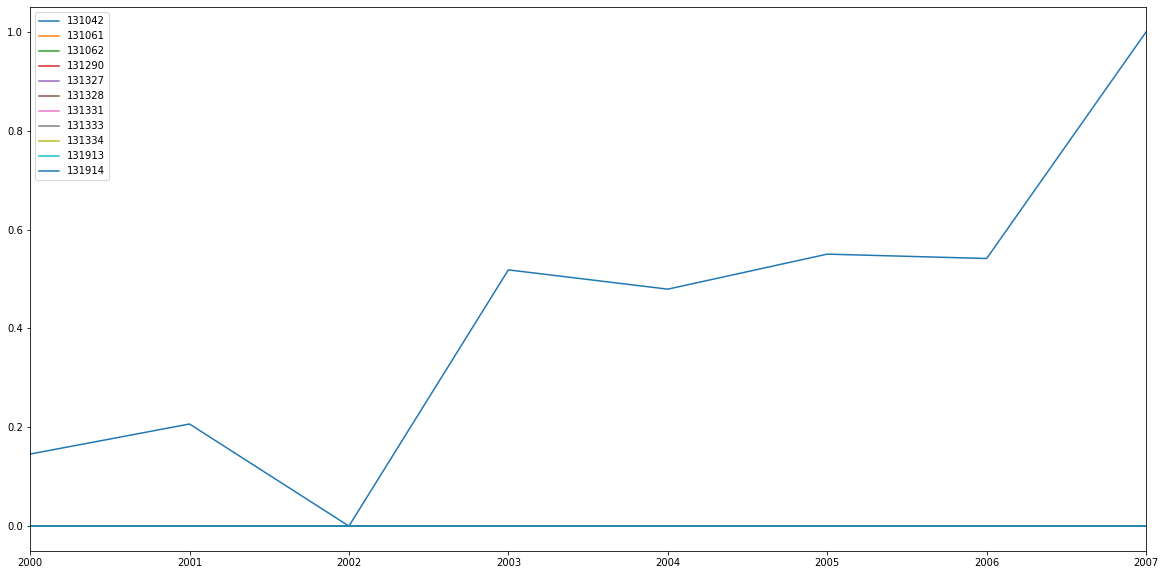

In [27]:

non_correlated_indicators=np.abs(df.loc[to_predict_ix,:]).sort_values(ascending=True).iloc[0:10].index.values
non_correlated_indicators=np.append(to_predict_ix, non_correlated_indicators)
non_correlated_indicators=train[train.index.isin(non_correlated_indicators)].loc[:,'2000':'2007'].T

pd.DataFrame(
    MinMaxScaler().fit_transform(non_correlated_indicators), 
    columns=non_correlated_indicators.columns, 
    index=non_correlated_indicators.index).plot(figsize=(20,10))

In [28]:
kenya_data.loc[correlated_indicators.columns]
# kenya_data.loc[to_predict_ix]

,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2001,2002,2003,2004,2005,2006,2007,Country_Name,Series_Code,Series_Name
131042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.742199e-01,6.250059e-01,7.485375e-01,7.392325e-01,7.561208e-01,7.540147e-01,8.632563e-01,Kenya,2.1,Achieve universal primary education
131412,1.325600e+10,1.728200e+10,2.071400e+10,2.298600e+10,2.710000e+10,3.280000e+10,3.900800e+10,4.411400e+10,4.981400e+10,5.755828e+10,...,9.747520e+11,9.907740e+11,1.078028e+12,1.190029e+12,1.313504e+12,1.507708e+12,1.711521e+12,Kenya,NE.CON.TOTL.CN,Final consumption expenditure (current LCU)
131418,1.325600e+10,1.728220e+10,2.071440e+10,2.298460e+10,2.712140e+10,3.278060e+10,4.088340e+10,4.413921e+10,4.989000e+10,5.833419e+10,...,9.313939e+11,9.343052e+11,1.012679e+12,1.137899e+12,1.271478e+12,1.496531e+12,1.683192e+12,Kenya,NE.CON.TETC.CN,"Final consumption expenditure, etc. (current LCU)"
131446,3.843510e+11,3.999772e+11,4.035058e+11,4.121972e+11,4.511655e+11,4.823523e+11,5.190845e+11,5.481116e+11,5.687948e+11,5.773636e+11,...,1.020006e+12,1.025584e+12,1.055659e+12,1.109543e+12,1.175080e+12,1.249470e+12,1.336849e+12,Kenya,NY.GDP.MKTP.KN,GDP (constant LCU)
131447,1.756600e+10,2.121400e+10,2.393400e+10,2.907200e+10,3.719800e+10,4.099460e+10,4.660400e+10,5.391000e+10,6.201600e+10,7.024780e+10,...,1.020221e+12,1.035373e+12,1.131782e+12,1.274329e+12,1.415725e+12,1.622567e+12,1.833513e+12,Kenya,NY.GDP.MKTP.CN,GDP (current LCU)
131467,3.682241e+11,3.865173e+11,3.924252e+11,3.953000e+11,4.341676e+11,4.652316e+11,5.006467e+11,5.315082e+11,5.514417e+11,5.562808e+11,...,1.008236e+12,1.016007e+12,1.044052e+12,1.099917e+12,1.174695e+12,1.245516e+12,1.329677e+12,Kenya,NY.GNP.MKTP.KN,GNI (constant LCU)
131468,1.684938e+10,2.049232e+10,2.325166e+10,2.788367e+10,3.588814e+10,3.954497e+10,4.492557e+10,5.226346e+10,6.007441e+10,6.746917e+10,...,1.008633e+12,1.025798e+12,1.119171e+12,1.263119e+12,1.415257e+12,1.617448e+12,1.823819e+12,Kenya,NY.GNP.MKTP.CN,GNI (current LCU)
131501,3.948551e+11,3.980916e+11,3.915702e+11,4.129136e+11,4.803014e+11,4.896536e+11,5.171044e+11,5.521066e+11,5.613314e+11,5.439622e+11,...,1.035087e+12,1.036754e+12,1.042924e+12,1.097210e+12,1.170350e+12,1.255441e+12,1.354686e+12,Kenya,NY.GDY.TOTL.KN,Gross domestic income (constant LCU)
131519,4.003470e+11,4.242280e+11,4.068880e+11,4.105115e+11,4.664653e+11,5.313790e+11,5.419404e+11,5.783151e+11,5.728968e+11,5.591231e+11,...,1.140733e+12,1.091252e+12,1.103743e+12,1.162766e+12,1.252455e+12,1.387591e+12,1.504715e+12,Kenya,NE.DAB.TOTL.KN,Gross national expenditure (constant LCU)
131520,1.779000e+10,2.274600e+10,2.505600e+10,2.887000e+10,3.594600e+10,4.499260e+10,4.933400e+10,5.735101e+10,6.410000e+10,7.369051e+10,...,1.123097e+12,1.091042e+12,1.199221e+12,1.354057e+12,1.521349e+12,1.796517e+12,2.033745e+12,Kenya,NE.DAB.TOTL.CN,Gross national expenditure (current LCU)
